# Large-scale networks for the self-optimization model enabled by on-the-fly computation of weights

Created by Natalya Weber

This jupyter notebook accompanies the paper: [Large-scale networks for the self-optimization model enabled by on-the-fly computation of weights](http://url)(link TBA)

## Import libraries

In [13]:
import os
import sys
import numpy as np
import pickle as pickle      
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Functions

####  Functions that generate different weight matrices 

In [14]:
rf = lambda n: np.random.choice(np.arange(-1,2,1), n, p=[0.5, 0, 0.5]) # {-1,1} with equal prob.
theta = lambda x: 1 if x >= 0 else -1     # Heaviside step function
                        
def sparseRandom(m, n, density=0.01, format='coo', dtype=None, random_state=None, data_rvs=None):
    "Generates a m*n random sparse symmetric matrix from {-1,0,1} with density d of nonzero values"
    def my_func(N, seed=None): 
        return random_state.choice(np.arange(-1,2,1), N, p=[0.5, 0, 0.5])
        # 'my_func' needs to be defined inside 'sparseRandom' to make sure that 
        # sampling the values of the structurally nonzero entries of the matrix 
        # uses the same random_state as the one used for sampling the sparsity structure  
    return sparse.random(m, n, density, format, dtype, random_state, my_func)

def w_sparse(N, d, seed_w):
    rng = np.random.default_rng(seed_w)
    w = sparseRandom(N, N, density = d, 
                      random_state = rng, 
                      dtype='f'           
                      ).astype('int8')    
    w = w.toarray()
    # make the matrix symmetric
    w = np.triu(w)
    w = w + w.T - np.diag(np.diag(w))
    return w

def w_modular(N, k, p):
    """Generates a modular consistent connectivity matrix of weights of size NxN where:
    - intramodule connections set to {-1,1} with equal probability
    - intermodule connections set to {-p,p} with equal probability
    - modules are of size k"""
    w = np.random.choice((-p,p),(N,N))
    
    for i in range(N):
        for j in range(N):
            if np.floor(i/k) == np.floor(j/k):
                w[i,j] = rf(1)
    w = np.triu(w) 
    w = w + w.T - np.diag(np.diag(w))
    return w

#### Simulation Functions

In [15]:
def Binary_update(state, w):
    """Eq. (1)"""
    idx = np.random.randint(len(state))
    oldState = state[idx] # save the value of s_i before updating it
    if (np.dot(w[idx,:], state)>0):
        state[idx] = 1
    else:
        state[idx] = -1    
    return idx, oldState                                                                                         

In [16]:
def learn(w, wOrig, steps, N, energies, doLearn):
    """Run the dynamics with or without learning (Eq.3), the direct routine """
    state = np.random.randint(0,2,N)*2-1  # Randomize initial discrete behaviours/states s_i={+-1}
    
    for step in range(steps):
        idx, oldState = Binary_update(state, w)

        if(doLearn):
            """Implementation C in the Appendix"""
            if(step == 0):
                # create the dw (weight matrix change) only once per reset
                dw = state[:,np.newaxis] * state[np.newaxis,:]
            else:
                # since only one discrete state changes, we need to update only one column and row
                if state[idx] > 0:
                    dw[idx,:] = state
                    dw[:,idx] = state
                else:
                    dw[idx,:] = -state
                    dw[:,idx] = -state
            w += dw 
        
        # Track history (including steps)
        if step==0:
            """ Eq. (2) """
            energies[step] = -0.5 * np.dot(state, np.dot(wOrig, state))
        else:
            """ Eq. (8) """
            energies[step] = energies[step-1] - (state[idx]-oldState) \
                * (np.dot(state,wOrig[:,idx]) - state[idx]*wOrig[idx,idx])

In [17]:
def updateW(w, dw, state, idx, idx2t, t2idx, t2state, t):
    newState = state[idx] * t2state[idx2t[idx]+1:t]
    indices = t2idx[idx2t[idx]+1:t]
    w[idx,indices] += (newState-dw[idx,indices]) * (t-np.arange(idx2t[idx]+1,t))
    dw[idx,indices] = newState

def learnSpeed(w, wOrig, steps, N, energies, doLearn):
    """Run the dynamics with or without learning (Algorithm 2), the on-the-fly routine """
    state = np.random.randint(0,2,N)*2-1    # Randomize initial discrete behaviours/states s_i={+-1}
    idx2t = np.zeros(N, dtype=int)          # Map between idx and time it was last changed ('ones' in Julia)
    t2idx = np.zeros(steps, dtype=int)      # The idx for which at time t the state was changed ('ones' in Julia)
    t2state = np.zeros(steps, dtype=int)    # history of all states after they were changed
    dw = np.zeros((N,N), dtype=int)
    
    for t in range(steps):
        idx = np.random.randint(len(state))
        oldState = state[idx]
        if doLearn:
            updateW(w, dw, state, idx, idx2t, t2idx, t2state, t)
            idx2t[idx] = t      # at what time idx changed
            t2idx[t] = idx      # what idx that was

        if (np.dot(w[idx,:],state) >= 0):
            state[idx] = 1
        else:
            state[idx] = -1
            
        if doLearn:
            t2state[t] = state[idx]    # save the state that was changed at time t
            if t==0:
                dw = state[:,np.newaxis] * state[np.newaxis,:]
            else:
                if state[idx] >= 0:
                    dw[idx,:] = state
                else:
                    dw[idx,:] = -state
        if t==0:
            """Eq. (2) """
            energies[t] = -0.5 * np.dot(state, np.dot(wOrig, state))
        else:
            """Eq. (8) """
            energies[t] = energies[t-1] - (state[idx]-oldState) \
                       * (np.dot(state,wOrig[:,idx]) - state[idx]*wOrig[idx,idx])
    if doLearn:
        t = steps
        for idx in range(N):
            updateW(w, dw, state, idx, idx2t, t2idx, t2state, t)

In [18]:
def beginRun(w, wOrig, energies, steps, resets, doLearn):
    start = np.array(os.times())
    
    for i in range(resets):
        if speed:
            learnSpeed(w, wOrig, steps, N, energies[i], doLearn)
        else:
            learn(w, wOrig, steps, N, energies[i], doLearn)
    
    # for process progress "visualization" print each 100 steps
    try:
        if i%(resets//10)==0:
            print('\r', i, end = '')
    except ZeroDivisionError:
        pass
    print('')
    
    duration = np.array(os.times()) - start
    print("""\nExecution time for N={} with L={}:\n""".format(N, doLearn), 
          [round(d, 4) for d in duration])

    sys.stdout.flush() # "flush" the buffer (write everything in the buffer to the terminal without waiting)

In [19]:
def simulate():
    np.random.seed(seed_w)
    energies = np.zeros((3*resets, steps), dtype=np.float64)
    
    if sparse_weights:
        w = w_sparse(N, d, seed_w)
    else:
        w = w_modular(N, k, p)  
    
    wOrig = np.array(w, dtype=float)
    w = np.array(w*eta, dtype=np.int64) # Eq. (4) 
    
    if randomSeed:
        np.random.seed(seed_sim)
        
    beginRun(w, wOrig, energies[:resets], steps, resets, False)
    beginRun(w, wOrig, energies[resets:resets*2], steps, resets, True)
    beginRun(w, wOrig, energies[resets*2:resets*3], steps, resets, False)
    
    
    with open(os.path.join(path,'output_{}_{}_ss{}'.format(N, eta, seed_sim)),'wb') as out:
        for thing in [energies, w, wOrig]:
            pickle.dump(thing, out)
        
    return energies, w, wOrig

In [20]:
def plot_6(energies, w, wOrig):
    resets = energies.shape[0]//3
    steps = energies.shape[1]
    
    fig,axs = plt.subplots(2,3,figsize=[15,10])
    img = axs[0,0].matshow(wOrig, aspect="auto");
    axs[0,0].title.set_text('Initial weights')
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(axs[0,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)     
    fig.colorbar(img, ax = axs[0,0], cax=cax)
    
    img = axs[0,1].matshow(w, aspect="auto");
    axs[0,1].title.set_text('Final weights')
    divider = make_axes_locatable(axs[0,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)     
    fig.colorbar(img, ax = axs[0,1], cax=cax)     

    E_NL = energies[resets-50:resets]
    
    axs[0,2].plot(np.arange(steps), E_NL.T)
    axs[0,2].title.set_text('Energies WoL')
    axs[0,2].set_xlabel("Timesteps")
    axs[0,2].set_ylabel("Energy")
    
    E_L = energies[resets+resets-50:resets*2]
    
    axs[1,2].plot(np.arange(steps)+steps, E_L.T)
    axs[1,2].title.set_text('Energies WL')
    axs[1,2].set_xlabel("Timesteps")
    axs[1,2].set_ylabel("Energy")
    
    axs[1,0].plot(np.arange(0,resets), energies[:resets,-1], c='tomato', ls='None', marker='o', markersize=2)
    axs[1,0].plot(np.arange(resets,resets*2), energies[resets:resets*2,-1], c='lightblue', ls='None', marker='o', markersize=2)
    axs[1,0].plot(np.arange(resets*2,resets*3), energies[resets*2:resets*3,-1], c='seagreen', ls='None', marker='o', markersize=2)
    axs[1,0].title.set_text('Attractor states visited')
    axs[1,0].set_xlabel("Resets")
    axs[1,0].set_ylabel("Energy")
    
    avg_fac = int(3*resets / 100)
    eMin,eMax=(energies[:,-1].min(),energies[:,-1].max())
    h = np.array([np.histogram(r,30,range=(eMin,eMax))[0] for r in energies[:,-1].reshape((avg_fac,100))]) 

    img = axs[1,1].matshow(h.T,origin="lower",extent=[0,avg_fac,eMin,eMax],aspect='auto') 
    axs[1,1].title.set_text('Histogram of attractor energies')
    divider = make_axes_locatable(axs[1,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)     
    fig.colorbar(img, ax = axs[1,1], cax=cax)
    axs[1,1].set_xlabel("Time window")
    axs[1,1].set_ylabel("Energy")
    
    if sparse_weights:
        main_title = r"N = " + str(N) + ", steps = " + str(steps) + ", resets = " + \
            str(resets) + ", α = " + str(alpha) + ", d = " + str(d) + \
                ", seed$_w$ = " + str(seed_w) + ", seed$_{sim}$ = " + str(seed_sim)
    else:
        main_title = r"N = " + str(N) + ", steps = " + str(steps) + ", resets = " + \
            str(resets) + ", α = " + str(alpha) + ", k = " + str(k) + \
                ", p = " + str(p) + ", seed$_w$ = " + str(seed_w) + ", seed$_{sim}$ = " + str(seed_sim)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle(main_title, y=0.99)
    
    if sparse_weights:
        fig_name = "N_" + str(N) + "_eta_" + str(eta) + "_ss_" + str(seed_sim)
    else:
        fig_name = "N_" + str(N) + "_eta_" + str(eta) + "_ss_" + str(seed_sim)
    plt.savefig(os.path.join(path, fig_name + '.png'))

In [21]:
def load_data(N,eta):
    with open(os.path.join(path,'output_{}_{}_ss{}'.format(N, eta, seed_sim)),'rb') as inData:
        energies = pickle.load(inData)
        w = pickle.load(inData)
        wOrig = pickle.load(inData)
        
    return energies, w, wOrig

## Initialize

In [22]:
speed = 1       # speed up by not explicitly adding w=w+dw
randomSeed = 1
seed_w = 12345
seed_sim = np.random.randint(90000)

N = 100
k = 5           # for modular w: size of module
p = 0.1         # for modular w: intermodule connections set to {-p,p} with equal probability
d = 0.1         # for sparse w: density of non-zero values

steps = 10*N
resets = 1000 
alpha = 5e-7

sparse_weights = False # True for sparse w, False for modular w

path = os.path.abspath(os.getcwd())
path = path + '/output/output_python'

if sparse_weights:
    path = path + "/Sparse"
else:
    path = path + "/Modular"

## Run the simulation 

In [23]:
if sparse_weights:
    path = path + "/N_" + str(N) + "/d_" + str(d)
    print("""\nStart simulation for sparse W\nN={}, d={}, a={}:\n""".format(N, d, alpha))
else:
    path = path + "/N_" + str(N) + "/k_" + str(k)
    print("""\nStart simulation for modular W\nN={}, k={}, a={}:\n""".format(N, k, alpha))

if not os.path.exists(path): os.makedirs(path)

eta = int(1/alpha)
simulate()
energies, w, wOrig = load_data(N,eta)


Start simulation for modular W
N=100, k=5, a=5e-07:



Execution time for N=100 with L=False:
 [21.1719, 0.0156, 0.0, 0.0, 0.0]


Execution time for N=100 with L=True:
 [45.9062, 0.0156, 0.0, 0.0, 0.0]


Execution time for N=100 with L=False:
 [20.2969, 0.0, 0.0, 0.0, 0.0]


## Visualization

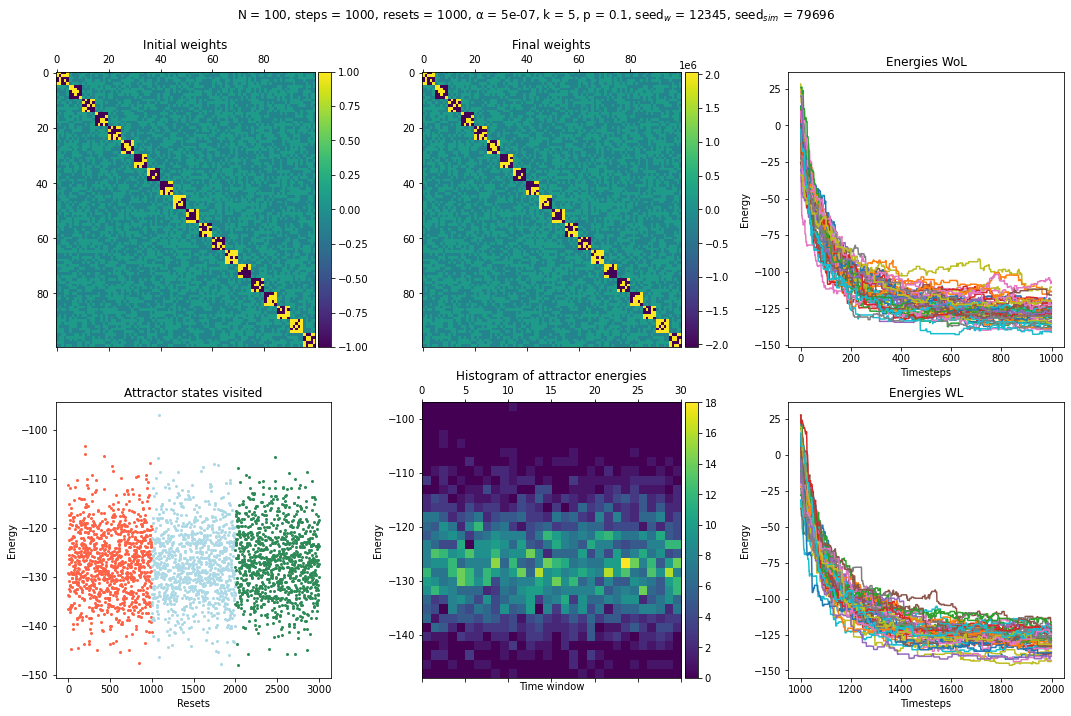

In [24]:
plot_6(energies, w, wOrig)